# Tarea 1: Técnicas de Machine Learning para la clasificación de imágenes
#### Integrantes:&ensp;&ensp;Claudio Macher Chávez
#### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;Pablo San Martín Domínguez
### Importaciones y configuración inicial:

In [182]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
ruta = "./archivo"
print(os.listdir(ruta))
dim = 100


['animals', 'name of the animals.txt']


### Obtener dataset de los animales seleccionados:

In [183]:
def getAnimales(animales, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Entrenamiento', 'Testing']
    if not k_fold:
        path = ruta + "/animals/" + data_type + "/"
        for i,f in enumerate(animales):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("Existen " , j , " imágenes de  " , data_type.upper(), " de " , animales[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = ruta + "/animals/" + v + "/"
            for i,f in enumerate(animales):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels

### Escoge tus animales para clasificación binaria:

In [184]:
#Escoge tus animales
animales = ['hummingbird' , 'pigeon'] # Clasificación binaria

#Get Images and Labels 
X_t, y_train =  getAnimales(animales, 'Entrenamiento', print_n=True, k_fold=False)
X_test, y_test = getAnimales(animales, 'Testing', print_n=True, k_fold=False)

#Get data for k-fold
X,y = getAnimales(animales, '', print_n=True, k_fold=True)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])
X = scaler.fit_transform([i.flatten() for i in X])

Existen  50  imágenes de   ENTRENAMIENTO  de  HUMMINGBIRD
Existen  50  imágenes de   ENTRENAMIENTO  de  PIGEON
Existen  10  imágenes de   TESTING  de  HUMMINGBIRD
Existen  10  imágenes de   TESTING  de  PIGEON


#### Se define la función para mostrar las imágenes en una grilla:

In [185]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1        

#### Se muestra la cuadrícula de imágenes de entrenamiento del primer animal:

hummingbird


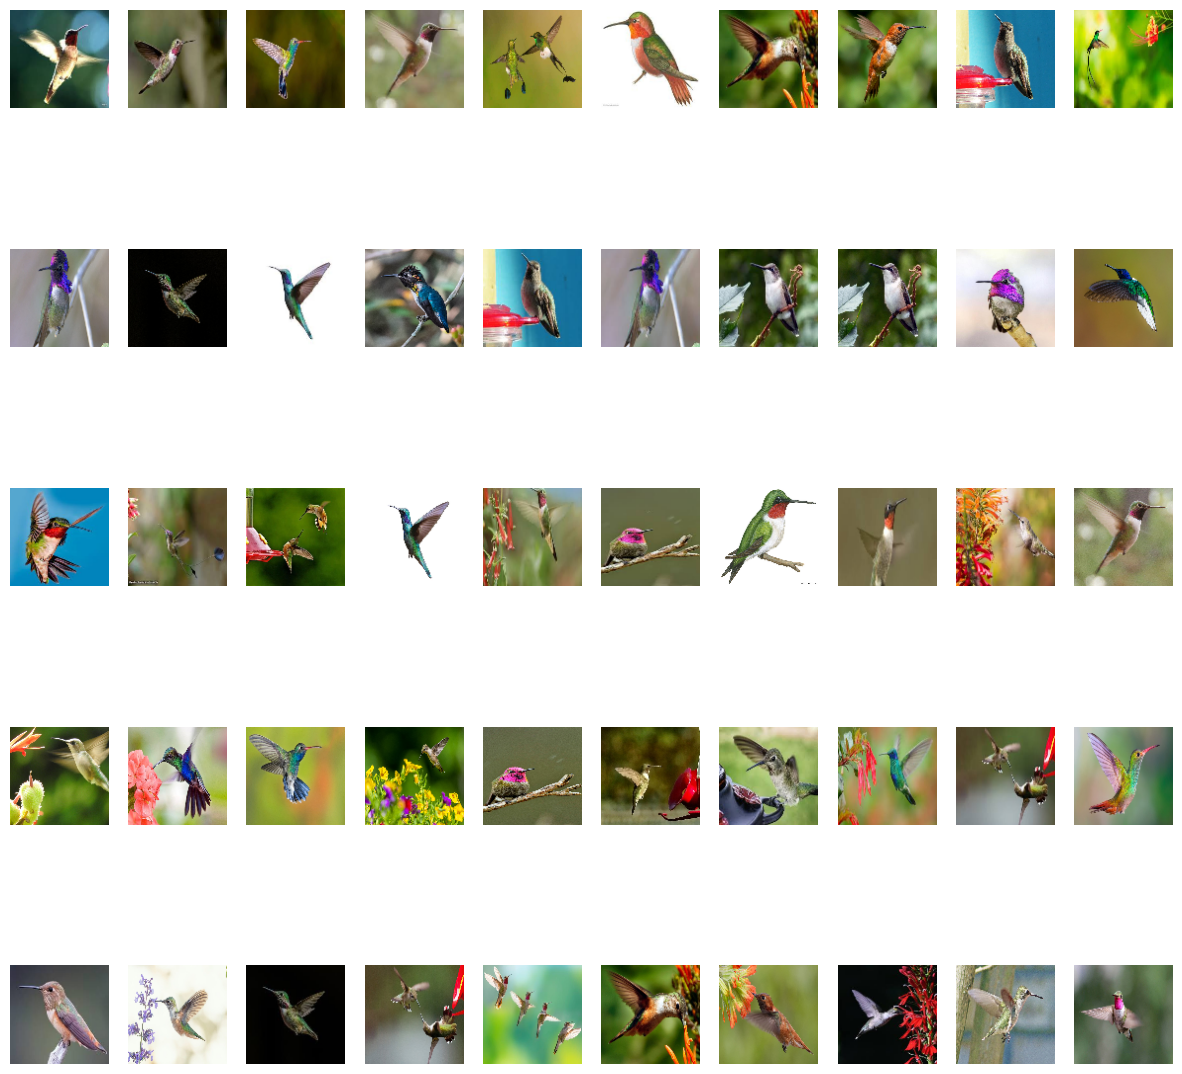

In [186]:
print(animales[y_train[0]])
plot_image_grid(X_t[0:50], 5, 10)

pigeon


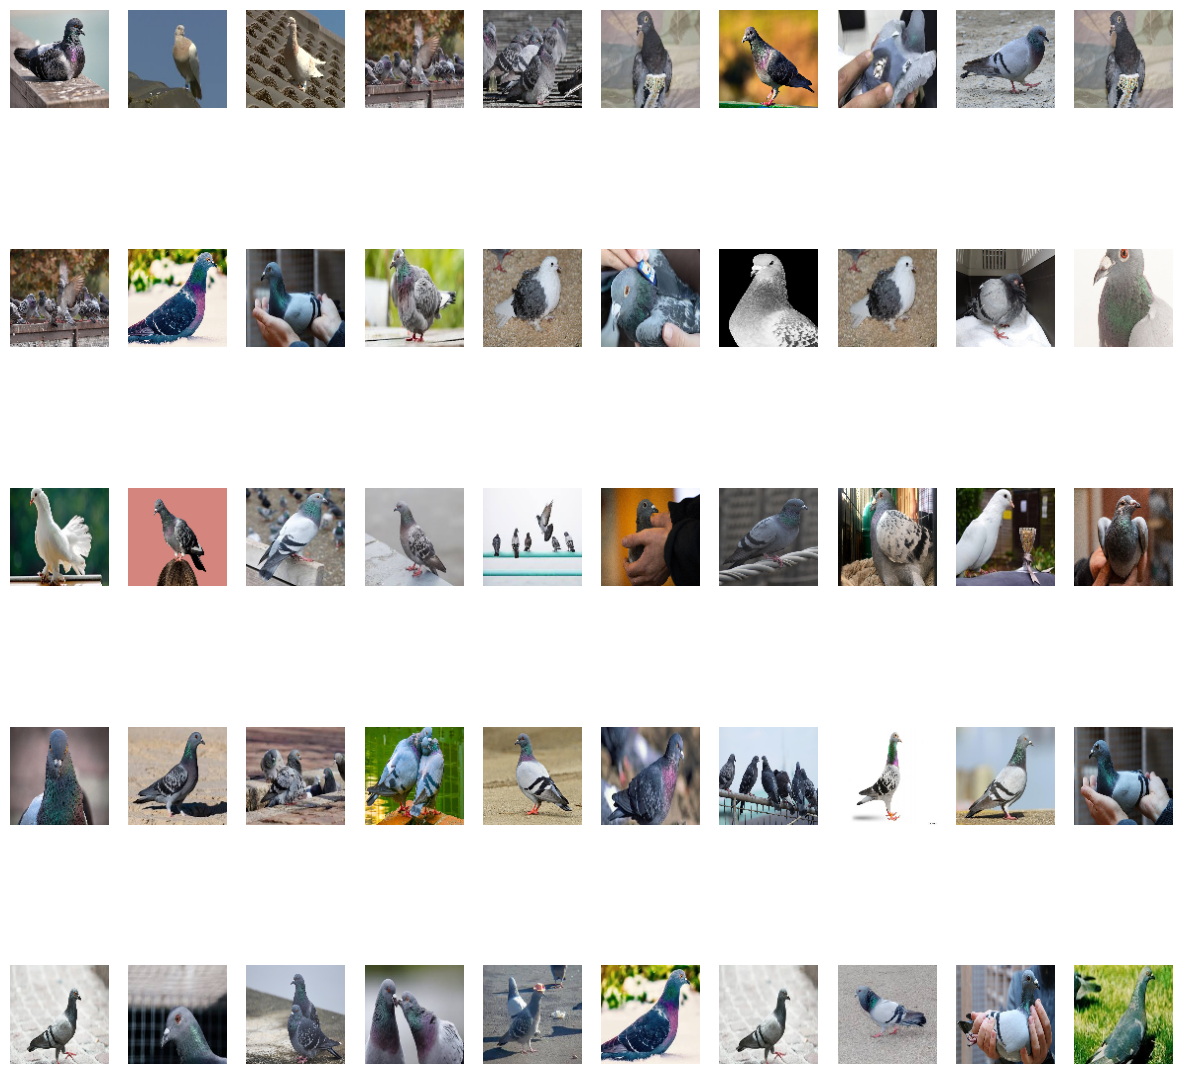

In [187]:
print(animales[y_train[50]])
plot_image_grid(X_t[50:100], 5, 10)

In [188]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

In [189]:

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = animales[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
   
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = animales[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

In [190]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=animales, yticklabels=animales,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

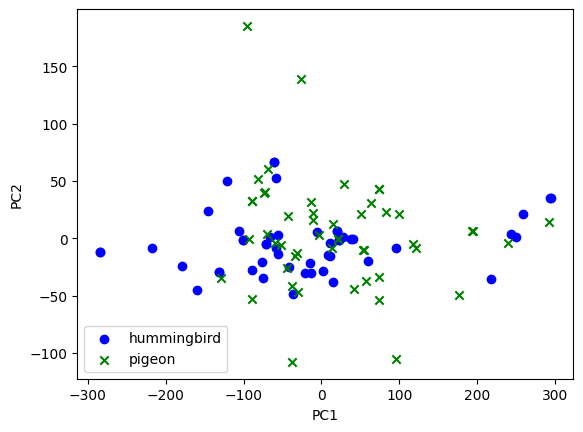

In [191]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 2)

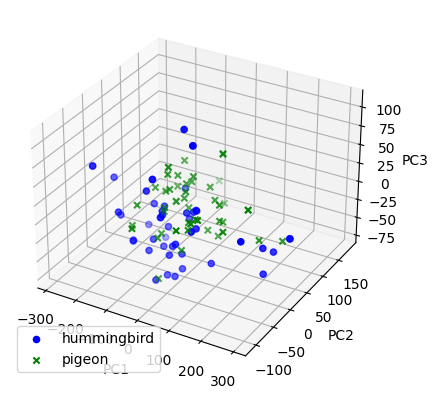

In [192]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn3D, 3)

### IMPLEMENTACIÓN DE ALGORITMO SVM

Accuracy with SVM: 80.00%


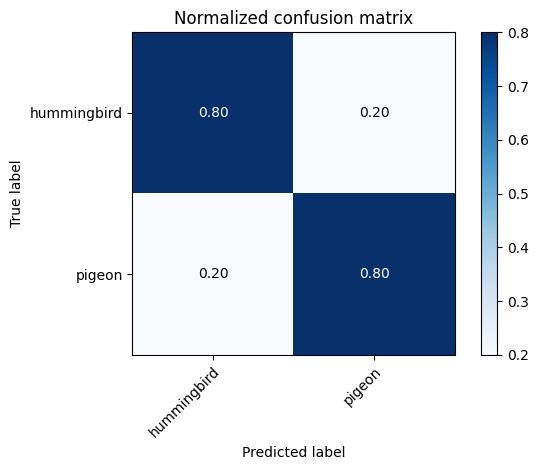

In [193]:
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred,classes=y_train,
normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

### SVM + K-FOLD

In [194]:
pred_kfold = cross_val_score(svm, X, y, cv=5)
print("Accuracy with SVM and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2)) 

Accuracy with SVM and K-FOLD CROSS VALIDATION: 0.81 (+/- 0.22)


### IMPLEMENTACIÓN DE ALGORITMO KNN

Accuracy with K-NN: 40.00%


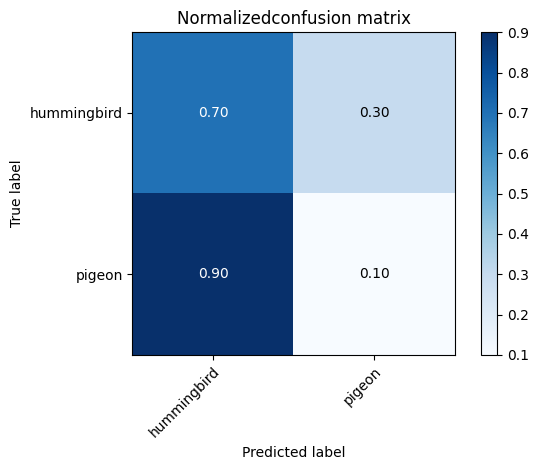

In [195]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalizedconfusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)

### KNN + K-FOLD

In [196]:
pred_kfold = cross_val_score(knn, X, y, cv=5)
print("Accuracy with K-NN and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" %
(pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with K-NN and K-FOLD CROSS VALIDATION: 0.59 (+/- 0.08)


### IMPLEMENTACIÓN DE ALGORITMO ÁRBOL DE DECISIÓN

Accuracy with Decision Tree: 80.00%


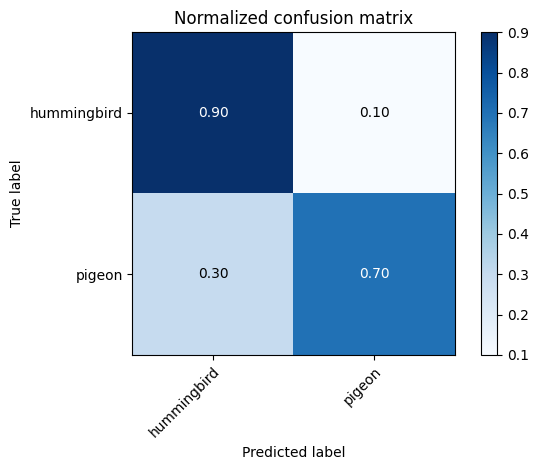

In [197]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = tree.predict_proba(X_test)
probs = probs[:, 1]
tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_test, probs)
tree_auc = metrics.roc_auc_score(y_test, probs)

### DECISION TREE + K-FOLD

In [198]:
pred_kfold = cross_val_score(tree, X, y, cv=5) 
print("Accuracy with DECISION TREE and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with DECISION TREE and K-FOLD CROSS VALIDATION: 0.69 (+/- 0.12)


### CARACTERÍSTICAS OPERATIVAS DEL RECEPTOR

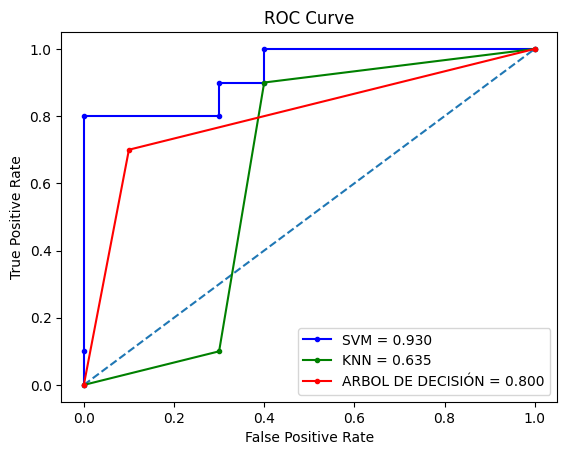

In [199]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'KNN = %0.3f' % knn_auc)
plt.plot(tree_fpr, tree_tpr, 'r', marker='.',label = 'ARBOL DE DECISIÓN = %.3f' % tree_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Definición de las técnicas como funciones

#### Función para obtener dataset de los animales seleccionados:

In [200]:
def cargarDatasets(animales):
    X_t, y_train =  getAnimales(animales, 'Entrenamiento', print_n=True, k_fold=False)
    X_test, y_test = getAnimales(animales, 'Testing', print_n=True, k_fold=False)
    X,y = getAnimales(animales, '', print_n=True, k_fold=True)
    scaler = StandardScaler()
    X_train = scaler.fit_transform([i.flatten() for i in X_t])
    X_test = scaler.fit_transform([i.flatten() for i in X_test])
    X = scaler.fit_transform([i.flatten() for i in X])

#### Función para aplicar SVM:

In [201]:
def aplicarSVM():
    svm = SVC(gamma='auto', kernel='linear', probability=True)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    precision = metrics.accuracy_score(y_pred, y_test) * 100
    return precision

#### Función para aplicar KNN:

In [202]:
def aplicarKNN():
    knn = KNeighborsClassifier(n_neighbors=2)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    precision = metrics.accuracy_score(y_pred, y_test) * 100
    return precision

#### Función para aplicar Decition Tree:

In [203]:
def aplicarDTree():
    tree = DecisionTreeClassifier()
    tree = tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    precision = metrics.accuracy_score(y_pred, y_test) * 100
    return precision

#### Impresión de los promedios obtenidos:

In [206]:
def imprimirPromedios():
    print("Promedio de precisión")
    print("SVM: {0:.2f}%".format(sumaSVM/cantidadDeDuplas))
    print("K-NN: {0:.2f}%".format(sumaKNN/cantidadDeDuplas))
    print("Decition Tree: {0:.2f}%".format(sumaDTree/cantidadDeDuplas))
    print("Promedio general de precisión: {0:.2f}%".format(((sumaSVM/cantidadDeDuplas)+(sumaKNN/cantidadDeDuplas)+(sumaDTree/cantidadDeDuplas))/3))

#### Se almacenan los nombres de las clases en un arreglo:

In [204]:
archivoNombres = open(ruta + "/name of the animals.txt", "r")
arreglo = archivoNombres.readlines()
nombres = []
for i in arreglo:
    nombres.append(i.strip('\n'))
archivoNombres.close()

#### Ejecución de las funciones para calcular el promedio de precisión:

In [209]:
import random
sumaSVM = 0
sumaKNN = 0
sumaDTree = 0
cantidadDeDuplas = 20
for i in range(cantidadDeDuplas):
    animalesRandom = nombres[random.randint(0,89)], nombres[random.randint(0,89)]
    print(animalesRandom)
    cargarDatasets(animalesRandom)
    sumaSVM += aplicarSVM()
    sumaKNN += aplicarKNN()
    sumaDTree += aplicarDTree()
imprimirPromedios()

('hummingbird', 'parrot')
Existen  50  imágenes de   ENTRENAMIENTO  de  HUMMINGBIRD
Existen  50  imágenes de   ENTRENAMIENTO  de  PARROT
Existen  10  imágenes de   TESTING  de  HUMMINGBIRD
Existen  10  imágenes de   TESTING  de  PARROT
('zebra', 'lion')
Existen  50  imágenes de   ENTRENAMIENTO  de  ZEBRA
Existen  50  imágenes de   ENTRENAMIENTO  de  LION
Existen  10  imágenes de   TESTING  de  ZEBRA
Existen  10  imágenes de   TESTING  de  LION
('panda', 'hummingbird')
Existen  50  imágenes de   ENTRENAMIENTO  de  PANDA
Existen  50  imágenes de   ENTRENAMIENTO  de  HUMMINGBIRD
Existen  10  imágenes de   TESTING  de  PANDA
Existen  10  imágenes de   TESTING  de  HUMMINGBIRD
('hippopotamus', 'dog')
Existen  50  imágenes de   ENTRENAMIENTO  de  HIPPOPOTAMUS
Existen  50  imágenes de   ENTRENAMIENTO  de  DOG
Existen  10  imágenes de   TESTING  de  HIPPOPOTAMUS
Existen  10  imágenes de   TESTING  de  DOG
('leopard', 'dolphin')
Existen  50  imágenes de   ENTRENAMIENTO  de  LEOPARD
Existen  50 

#### Chillán, Chile
#### Viernes 28 de octubre de 2022